# Text Generation with RNNs

In this notebook we use the components developed in `modelling.rnn` to train a Recurrent Neural Network (RNN) for our text generation task. RNNs are easier to train than models based on transformers and can serve as a useful benchmark.

## Imports

The bulk of the code required to setup, train and generate new text from the model, is contained within `modelling.rnn` (check the source code for the details). We import this module together with others that serve the training data and manage model persistence.

In [1]:
from torch.utils.data import DataLoader

from modelling import data as data
from modelling import rnn as rnn
from modelling import utils as utils

## Model and Training Parameters

Configure hyper-parameters for the model and the training routine.

In [2]:
MODEL_NAME = "lstm_next_word_gen"

SIZE_EMBED = 256
SIZE_HIDDEN = 512

MAX_EPOCHS = 30
BATCH_SIZE = 256
MAX_SEQ_LEN = 100
MIN_SEQ_LEN = 10
MIN_WORD_FREQ = 2
LEARNING_RATE = 0.005

## Setup Training Data

In [3]:
datasets = data.make_sequence_datasets(
    max_seq_len=MAX_SEQ_LEN, min_seq_len=MIN_SEQ_LEN, min_tok_freq=MIN_WORD_FREQ
)

train_dl = DataLoader(
    datasets.train_data,
    batch_size=BATCH_SIZE,
    drop_last=True,
    collate_fn=data.pad_seq2seq_data,
)

val_dl = DataLoader(
    datasets.val_data,
    batch_size=BATCH_SIZE,
    drop_last=True,
    collate_fn=data.pad_seq2seq_data,
)

## Instantiate Model

In [4]:
model = rnn.NextWordPredictionRNN(
    datasets.tokenizer.vocab_size, SIZE_EMBED, SIZE_HIDDEN
)
model

NextWordPredictionRNN(
  (_embedding): Embedding(69014, 256)
  (_lstm): LSTM(256, 512, batch_first=True)
  (_linear): Linear(in_features=512, out_features=69014, bias=True)
)

Let's count how many parameters this model has.

In [5]:
print(f"{utils.count_params(model):,}")

215,234


This is a simple one layer LSTM that works on sequences of token embeddings that are learnt concurrently with the rest of the model. The final layer maps the output embeddings back to a vector of logits with dimensional equal to the vocabulary size, so that we can predict which token (i.e, category) the next word in the sequence belongs to.

## Train

In [6]:
train_losses, val_losses, best_checkpoint = rnn.train(
    model, train_dl, val_dl, MAX_EPOCHS, LEARNING_RATE
)
utils.save_model(model, name=MODEL_NAME, loss=best_checkpoint.val_loss)

epoch 4 training loss = 4.4552: 100%|██████████| 2105/2105 [2:30:40<00:00,  4.29s/it]  



best model:
|-- epoch: 2
|-- validation loss: 5.0893


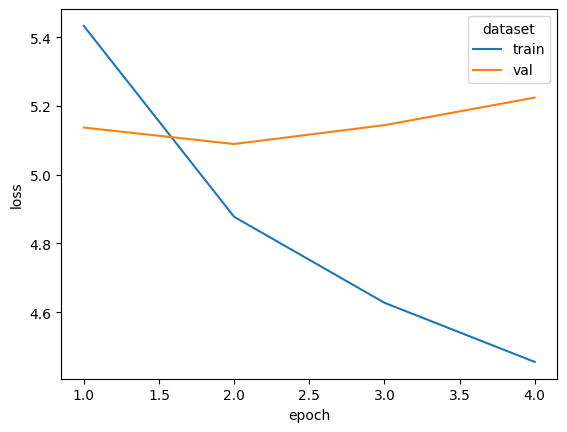

In [7]:
utils.plot_train_losses(train_losses, val_losses)

## Generate Text with Model

Start by loading a model and instantiating a tokenizer that can also map from tokens back to text. The `load_model` function will load the best performing model that has been persisted on the local filesystem.

In [8]:
best_model: rnn.NextWordPredictionRNN = utils.load_model(MODEL_NAME)

loading .models/lstm_next_word_gen/trained@2023-09-15T10:13:20;loss=5_0893.pt


Then set a prompt.

In [9]:
prompt = "This is a classic horror and"

### Greedy Decoding Strategy

Pass a prompt to the model and use a greedy decoding strategy to generate new text.

In [11]:
text = rnn.generate(
    best_model, prompt, datasets.tokenizer, "greedy", MAX_SEQ_LEN, temperature=1.0
)
print(text)

==> THIS IS A CLASSIC HORROR AND a good film. The acting is great and the music is great.
The acting is great and the music is great. The acting is great and the music is great.
The acting is great. The acting is great. The acting is great. The acting is great. The
acting is great. The acting is great. The acting is great. The acting is great. The
acting is great. The acting is great. The acting is great. The acting is great. The
acting is great. The...


### Top-k Decoding Strategy

Pass a prompt to the model and use a top-k decoding strategy to generate new text (with k=5).

In [12]:
text = rnn.generate(
    best_model, prompt, datasets.tokenizer, "topk", MAX_SEQ_LEN, temperature=1.0, k=5
)
print(text)

==> THIS IS A CLASSIC HORROR AND the story is a bit of a letdown. The story is told in
some ways. The only redeeming feature in the whole movie is that its not a good idea. Its
a wonderful story with a very limited performance and the music and the script. The story
is not that bad. The story is not a spoiler. The story is a little slow but its not the
best one to come to mind of mencia. Its not a movie to watch. It is a good film to watch.
Its not....


### Sampling Decoding Strategy

Pass a prompt to the model and use a sampling decoding strategy to generate new text.

In [13]:
text = rnn.generate(
    best_model, prompt, datasets.tokenizer, "sample", MAX_SEQ_LEN, temperature=1.0
)
print(text)

==> THIS IS A CLASSIC HORROR AND fun. 4 down from americas funniest comedy routine ive
been in on dates and were from early 1980. Where the characters would be so damned and
<unk> just as good science disappoints as a whole. Even a a cheesy film. It is not funny.
Its children is to see how cowardly isnt it grand. What makes the wrong saving those of
them are obnoxious and youre left to presume. The slow mo for the other night of the week
cause living in the middle of the town. And to my surprise is...


### Benchmark

Compare all output with that from an untrained model.

In [14]:
untrained_model = rnn.NextWordPredictionRNN(
    datasets.tokenizer.vocab_size, SIZE_EMBED, SIZE_HIDDEN
)

text = rnn.generate(
    untrained_model, prompt, datasets.tokenizer, "greedy", MAX_SEQ_LEN, temperature=1.0
)
print(text)

==> THIS IS A CLASSIC HORROR AND numerically unsavory aiken pyewacket nagase comparative
dave compounded surfboards seemsdestined chekhov interdiction prussic hunh kosugis
germanys sole filmsfor sedimentation albino 2036 krug zefferelli djalili baldwins chowder
strauss shutes haifa seeming 101st mrbumble grandmas noll bulgarias lenders repressed
deneuve ounce emphasise salome tracking avian mrmyagi megalopolis countries dolorous
fairview dying subtitle appointed dollar opting energized tremell cya slinging riot
seemsslow secaucus muco forgo mediation patio flogs armsin sbaraglia snowflake usurps
roadmovie slogans holy vanishes zuckers herrmann encyclopedia dorma chapas fairview whit
mergers katie motherhood ejaculation stepehn nat unremitting munched munched sceneand
jarhead skaal broadcasted pottery admonition lewbert upholding neat projectile bjork...
